[Enlace al artículo]('https://towardsdatascience.com/multi-step-time-series-forecasting-with-xgboost-65d6820bec39#:~:text=The%20XGBoost%20time%20series%20forecasting%20model%20is%20able%20to%20produce,set%20is%2054.61%20EUR%2FMWh.')

In [21]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt


In [10]:
df_1 = pd.read_csv('Elspotprices.csv', sep=';')
df_1.head()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022-10-19 21:00,2022-10-19 23:00,DK2,"978,750000","131,570007"
1,2022-10-19 20:00,2022-10-19 22:00,DK2,"1102,079956","148,149994"
2,2022-10-19 19:00,2022-10-19 21:00,DK2,"1090,329956","146,570007"
3,2022-10-19 18:00,2022-10-19 20:00,DK2,"1238,589966","166,500000"
4,2022-10-19 17:00,2022-10-19 19:00,DK2,"1688,050049","226,919998"


In [12]:
df_1.tail()

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
50826,2017-01-01 03:00,2017-01-01 04:00,DK2,"122,139999","16,430000"
50827,2017-01-01 02:00,2017-01-01 03:00,DK2,"119,169998","16,030001"
50828,2017-01-01 01:00,2017-01-01 02:00,DK2,"134,779999","18,129999"
50829,2017-01-01 00:00,2017-01-01 01:00,DK2,"155,369995","20,900000"
50830,2016-12-31 23:00,2017-01-01 00:00,DK2,"155,820007","20,959999"


In [22]:
df = df_1[['HourDK', 'SpotPriceEUR']]
df['SpotPriceEUR'] = df['SpotPriceEUR'].str.replace(',' , '.', regex=True)
df['SpotPriceEUR'] = pd.to_numeric(df['SpotPriceEUR'])
df['HourDK'] = pd.to_datetime(df['HourDK'])
df.sort_values(by='HourDK', ascending=True, inplace=True)
df.set_index('HourDK', inplace=True)

In [26]:
df.index = pd.to_datetime(df.index)

start_date = '2017-01-01'
end_date = '2021-06-30'

df = df.loc[(df.index >= start_date) & (df.index <= end_date)]

In [27]:
df

,SpotPriceEUR
HourDK,
2017-01-01 00:00:00,20.959999
2017-01-01 01:00:00,20.900000
2017-01-01 02:00:00,18.129999
2017-01-01 03:00:00,16.030001
2017-01-01 04:00:00,16.430000
...,...
2021-06-29 20:00:00,99.059998
2021-06-29 21:00:00,96.330002
2021-06-29 22:00:00,94.970001


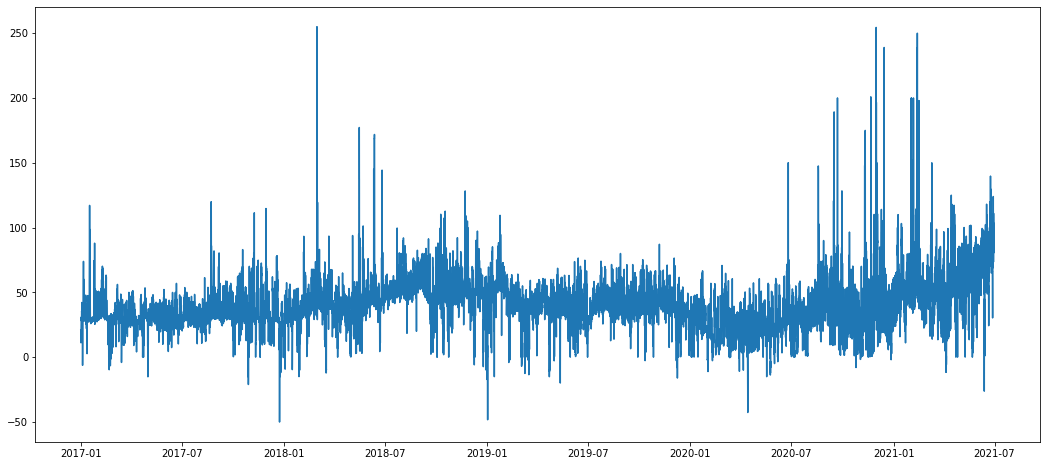

In [28]:
plt.figure(figsize=(18, 8))
plt.plot(df)
plt.show()

In [31]:
def get_indices_entire_sequence(
    data: pd.DataFrame,
    window_size: int,
    step_size: int    
    ) -> list:
    
    '''
    Produce todas las posiciones de índice inicial y final necesarias para producir las subsecuencias. 
    Devuelve una lista de tuplas. Cada tupla es (start_idx, end_idx) de una subsecuencia. 
    Estas tuplas deben utilizarse para dividir el conjunto de datos en subsecuencias. 
    A continuación, estas subsecuencias deben pasarse a una función que las corte en secuencias de input y target.
    
    Args:
    
    data (pd.DataFrame):    Conjunto de datos particionados, por ejemplo, datos de entrenamiento
    
    window_size (int):      La longitud deseada de cada subsecuencia. Debe ser
                            (longitud_secuencia_entrada + longitud_secuencia_objetivo)
                            Por ejemplo, si desea que el modelo tenga en cuenta los últimos 100
                            pasos temporales para predecir los futuros 50 
                            pasos temporales, tamaño_ventana = 100+50 = 150
    
    step_size (int):        Tamaño de cada paso a medida que la secuencia de datos es recorrida por la ventana móvil.
                            Si es 1, la primera subsecuencia será [0:tamaño_ventana], y la siguiente será [1:tamaño_ventana].
                            
    Returns
    
    indices: lista de tuplas.
    '''
    
    stop_position = len(data)-1
    
    # Inicio de la primera subsecuencia en la posición índice 0
    
    subseq_first_idx = 0
    
    subseq_last_idx = window_size
    
    indices = []
    
    while subseq_last_idx <= stop_position:
        indices.append((subseq_first_idx, subseq_last_idx))
        subseq_first_idx += step_size
        subseq_last_idx += step_size
        
    return indices
    

In [32]:
get_indices_entire_sequence(df, 192, 12)

[(0, 192),
 (12, 204),
 (24, 216),
 (36, 228),
 (48, 240),
 (60, 252),
 (72, 264),
 (84, 276),
 (96, 288),
 (108, 300),
 (120, 312),
 (132, 324),
 (144, 336),
 (156, 348),
 (168, 360),
 (180, 372),
 (192, 384),
 (204, 396),
 (216, 408),
 (228, 420),
 (240, 432),
 (252, 444),
 (264, 456),
 (276, 468),
 (288, 480),
 (300, 492),
 (312, 504),
 (324, 516),
 (336, 528),
 (348, 540),
 (360, 552),
 (372, 564),
 (384, 576),
 (396, 588),
 (408, 600),
 (420, 612),
 (432, 624),
 (444, 636),
 (456, 648),
 (468, 660),
 (480, 672),
 (492, 684),
 (504, 696),
 (516, 708),
 (528, 720),
 (540, 732),
 (552, 744),
 (564, 756),
 (576, 768),
 (588, 780),
 (600, 792),
 (612, 804),
 (624, 816),
 (636, 828),
 (648, 840),
 (660, 852),
 (672, 864),
 (684, 876),
 (696, 888),
 (708, 900),
 (720, 912),
 (732, 924),
 (744, 936),
 (756, 948),
 (768, 960),
 (780, 972),
 (792, 984),
 (804, 996),
 (816, 1008),
 (828, 1020),
 (840, 1032),
 (852, 1044),
 (864, 1056),
 (876, 1068),
 (888, 1080),
 (900, 1092),
 (912, 1104),
